<font size="40"> Ships recognition in satellite images</font>

# Executive summary

## Problem setup
Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day.

This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process.

## Solution
This notebook describes building a CNN (convolutional neural network) capable of distinguishing whether a presented satellite image has a ship on it. I use transfer learning on two publicly available pretrained CNNs (VGG16 and Inception), building classifiers on top of them, and compare those.
1. The dataset [Ships in Satellite Imagery](https://www.kaggle.com/rhammell/ships-in-satellite-imagery) has 1000 positive (ship) and 3000 negative examples, with each image being 80x80 px RGB
2. Final classifiers provide @@ accuracy on unseen data

# Pipeline description

This is an overview of the entire project structure, or pipeline:
1. Aquire the data from a public dataset on kaggle
2. Perform basic EDA (exploratory data analysis)
3. Use data augmentation to compensate for skewness (there is only on ship example for each 3 no-ships)
4. Use pretrained CNNs (VGG16 and Inception) to calculate feature vectors for each image
5. Split the data into train/dev/test sets
6. Build and train classifiers on top of the pretrained CNNs
7. Use the dev set to perform hyperparameters optimization and choose the best solution (combination of pretrained CNN + new classifier)
8. Use the test set to estimate the real-world performance of the algorithm on unseen data

# Working with data

## Import libraries
Following packages will be needed for further processing:

In [288]:
import os # reading files and folders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # display images
import imgaug.augmenters as iaa # data augmentation
from sklearn.model_selection import train_test_split

from tqdm import tqdm # progress bar for loops
import cv2 #OpenCV for computer vision

from tensorflow.keras.utils import to_categorical # one-hot encoding
from tensorflow.keras.layers import Dense, Dropout # layers to build my classifiers
from tensorflow.keras import Sequential, optimizers

import dill # save session data

## Load data
The data was downloaded manually and separated into ship and no-ship folders

In [276]:
data_location = 'data/shipsnet'
class_names = ["no-ship","ship"]
class_name_labels = {class_name:i for i,class_name in enumerate(class_names)} # dictionary of class names: ids
num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

Load images as CV2 format, normalize pixel values and read labels

In [277]:
images, labels = [], []
     
for folder in os.listdir(data_location):
    label = class_name_labels[folder]

    for file in tqdm(os.listdir(os.path.join(data_location,folder))):

        img_path = os.path.join(data_location,folder,file)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # OpenCV loads images as BGR while matplotlib will need RGB to display them

        images.append(img)
        labels.append(label)
        pass
    pass

images = np.array(images,dtype=np.float32) /255.0 # Normalize data
labels = np.array(labels,dtype=np.float32)

images.shape, labels.shape

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1388.71it/s]


((4000, 80, 80, 3), (4000,))

## EDA
Let's see the distribution of data betweeen classes

In [278]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


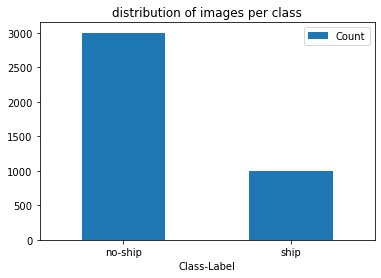

In [150]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

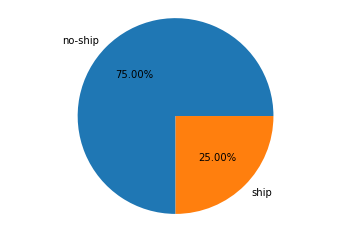

In [279]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

**For each ship image, there are 3 no-ship ones.** Such skewness will have to be corrected for, otherwise the alogrithm will be able to achieve 75% accuracy just by always predicting "no-ship" which will create unnecessary bias.

Let's now see a few images. First row is no-ship, second row are ships.

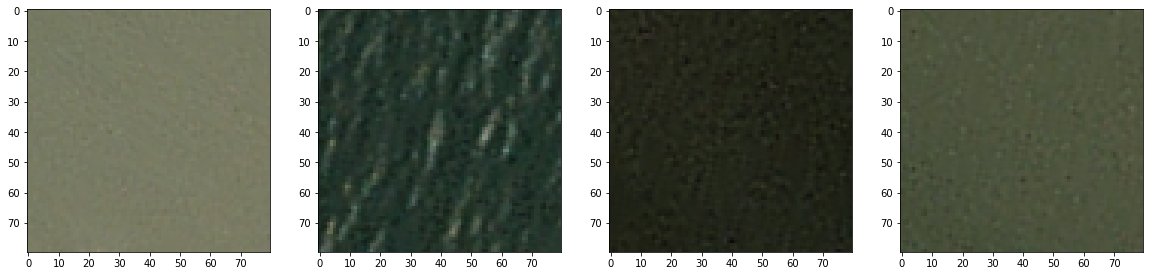

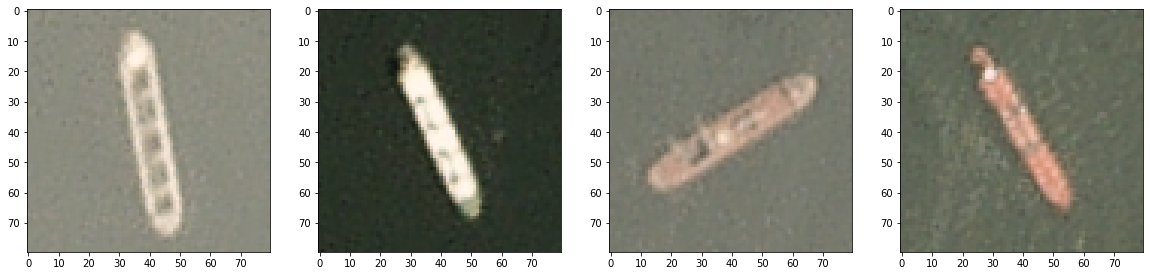

In [280]:
columns = 4
rows = 1

# no ships are images from 0 to 3000
fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    img = images[np.random.choice(3000)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# ships are from 3000 to 4000
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 1
for i in range(1, columns*rows +1):
    img = images[np.random.choice(1000)+3000]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()


It is worth noting that only a full image of the vessel is considered to belong to ship class. No-ship sometimes can contain a part of a ship.

## Data augmentation
One way to adjust for skewness of the classes is to create more examples of 'ship' class by adding two augmented versions of each one. Another would be to assign class weights when training, which will be done in a later section in order to compare the results.

In [281]:
def augment_add(images, seq, labels):
    
    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):
        
        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass
    
    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)
    
    return (augmented_images, augmented_labels)

In [282]:
# several ways of augmentation, applied randomly
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [283]:
np.random.seed(41) # augmentation is a random process so setting the seed for reproducible resultsd
(aug_images, aug_labels) = augment_add(images, seq, labels)
aug_images = np.concatenate([images, aug_images])
aug_labels = np.concatenate([labels, aug_labels])

4000it [00:05, 690.19it/s]  


In [284]:
images.shape, labels.shape, aug_images.shape, aug_labels.shape

((4000, 80, 80, 3), (4000,), (6000, 80, 80, 3), (6000,))

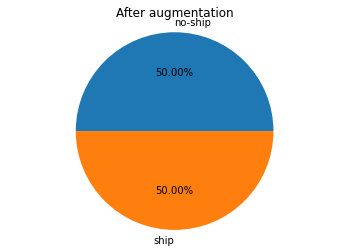

In [285]:
_, count = np.unique(aug_labels, return_counts=True)

plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal')
plt.title("After augmentation");

Great, we now have an equal amount of images in both classes, 3000 each.

## Train/dev/test split

I will split the entire dataset into train/dev/test using 70/20/10 ratio appropriate for a relatively small number of examples I have.
1. Train set will be used to train classifiers
2. Dev set will be used to compare different approaches with each other and choose the best one. Each one comprises:
    + underlying pretrained CNN
    + classifier with its hyperparameters
    + a choice of correcting for skewed classes: either data augmentation or class weights
3. Test set will be used only once to estimate the performance of the best model on unseen data

* `train_test_split` function from `scikitlearn` only allows splitting into two sets (train and test), so I will use it twice, first splitting all data into train and test, and then splitting test into dev and test proper
* as I want to compare data augmentation with class weights approach, I will need the dev set to be the same for both; for that, I will
    + split just the original data into dev/

In [241]:
ids = list(range(0, features.shape[0])) # need to store and shuffle IDs to be able to find mislabelled pics later

np.random.seed(40)
np.random.shuffle(images)

np.random.seed(40)
np.random.shuffle(labels)

np.random.seed(40)
np.random.shuffle(ids)

In [242]:
total_count = len(images)
total_count

train = int(0.7*total_count)
dev = int(0.2*total_count)
test = int(0.1*total_count)

# one-hot encoding may seem silly when we only have two classes but initially the labels are float and that won't work for training

labels = to_categorical(labels)

train_images, train_labels, train_ids = images[:train], labels[:train], ids[:train]
dev_images, dev_labels, dev_ids = images[train:(dev+train)], labels[train:(dev+train)], ids[train:(dev+train)]
test_images, test_labels, test_ids = images[-test:], labels[-test:], ids[-test:]

train_images.shape, dev_images.shape, test_images.shape

((4200, 80, 80, 3), (1200, 80, 80, 3), (600, 80, 80, 3))

# Transfer learning
The amount of original data (only 4000 examples) is not enough to train a CNN from scratch. It makes more sense to reuse some publicly available models that have been trained over several weeks using GPU on millions of examples. Thus I will be able to transfer the existing knowledge about low-level features (borders, angles etc) and only learn the actual classification between ships and no-ships.

This will be a two step process:
1. Use pretrained CNN (without the final fully connected and classifier layers) to calculate feature vectors for each image (deterministic step, as no training will be done here)
2. Build and train a separate classifier, using feature vectors from step 1 as an input

## VGG16

VGG16 is a deep CNN with 16 trainable layers that made history by achieving 92.7% top-5 test accuracy on ILSVRC-2014 competition by ImageNet. You can read about it [in this article](https://neurohive.io/en/popular-networks/vgg16/), but here is the architecture for general understanding. 

![VGG16 architecture](vgg16.png "VGG16 architecture")

### Load model

There are two parts to a CNN model: the network architecture (displayed above) and the weights after training. For transfer learning, we'll need both, and both very conveniently are now available via keras package.

However, out of VGG16 original 16 trainable layers (not counting pooling and softmax), only the first 13 are convolutional layers, and last 3 are fully connected ones that perform  classification. I will only load the convolutional layers and build my own classifier on top of that. A nice perk is that it will allow me to use any size image for input (generating different size features vectors for output), because otherwise VGG16 only accepts 256x256 px format.

In [243]:
from tensorflow.keras.applications import vgg16 # this imports the architecure

vgg_conv = vgg16.VGG16(weights='imagenet', # loads the weights, first time they will be downloaded from the github but then saved locally
                  include_top=False, # do not load fully connected layers
                  input_shape=(80, 80, 3)) # shape of the images in ships dataset

### Calculate features

First pass all the images through VGG16 to get feature tensors. With a 256x256x3 image, the result would be 7x7x256, but with a 80x80x3 ones that I am using it will be smaller, some kind of n x n x 256, where n < 7. This step takes a few minutes.

In [244]:
vgg_train, vgg_dev, vgg_test = vgg_conv.predict(train_images), vgg_conv.predict(dev_images), vgg_conv.predict(test_images)
vgg_train.shape, vgg_dev.shape, vgg_test.shape

((4200, 2, 2, 512), (1200, 2, 2, 512), (600, 2, 2, 512))

Okay resulting tensors are 2x2x512. Need to flatten them into feature vectors because this is what fully connected layers like.

In [245]:
def flatten(tensor): # this function will be reused when flattening Inception features that have a different shape
    return np.reshape(tensor, (tensor.shape[0], tensor.shape[1] * tensor.shape[2] * tensor.shape[3]))

vgg_train, vgg_dev, vgg_test = flatten(vgg_train), flatten(vgg_dev), flatten(vgg_test)
vgg_train.shape, vgg_dev.shape, vgg_test.shape

((4200, 2048), (1200, 2048), (600, 2048))

Perfect, now each image is represented with a 2048-long feature vector.

## Inception

While VGG is conceptually a bunch of convolutional layers stacked upon each other, Inception has more complicated structure. Fully describing it is out of scope of this notebook (you can read a good overview [here](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)). I will only mention that it creates a "sparsely connected architecture" by stacking up a new kind of bricks called "Inception modules":
![Inception module](inception_module.png "Inception module")

Among other things, this makes the network less expensive to train and less prone to overfitting.

For my particular task, I will just load the architecture and weights (without the top fully connected layers) and use them to calculate feature vectors as with VGG.

### Load model

In [246]:
from tensorflow.keras.applications import inception_v3

incep_conv = inception_v3.InceptionV3(weights='imagenet', 
                  include_top=False,
                  input_shape=(80, 80, 3))

### Calculate features

By analogy with VGG, first get features as tensors:

In [247]:
incep_train, incep_dev, incep_test = incep_conv.predict(train_images), incep_conv.predict(dev_images), incep_conv.predict(test_images)
incep_train.shape, incep_dev.shape, incep_test.shape

((4200, 1, 1, 2048), (1200, 1, 1, 2048), (600, 1, 1, 2048))

It's interesting that both VGG16 and Inception end up with the same size features, although shaped differently.

Now flatten:

In [248]:
incep_train, incep_dev, incep_test = flatten(incep_train), flatten(incep_dev), flatten(incep_test)
incep_train.shape, incep_dev.shape, incep_test.shape

((4200, 2048), (1200, 2048), (600, 2048))

# Own model (classifier)

Due to the lucky coincidence that VGG16 and Inception output feature vectors of the same size, I can use the same classifier architurecture, feed it both outputs and compare.

## Define architecture

0. Input is 2048-length feature vector
1. Fully connected layer with 1024 neurons and ReLU activation
2. Dropout with 0.5
3. Two-unit output layer with softmax activation: each unit will predict the probability of its class

In [269]:
def my_classifier():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=2048))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

Create two classifiers (so far exactly the same) to be used with VGG and Inception respectively

In [270]:
vgg_classifier = my_classifier()
incep_classifier = my_classifier()

## Train

### VGG classifier

In [271]:
# Train VGG classifier
vgg_history = vgg_classifier.fit(vgg_train,
                    train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(vgg_dev, dev_labels)
)

Train on 4200 samples, validate on 1200 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
4200/4200 [==============================] - 6s 1ms/sample - loss: 0.1208 - acc: 0.9529 - val_loss: 0.1045 - val_acc: 0.9625
Epoch 2/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0579 - acc: 0.9786 - val_loss: 0.0563 - val_acc: 0.9792
Epoch 3/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0464 - acc: 0.9829 - val_loss: 0.0492 - val_acc: 0.9842
Epoch 4/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0362 - acc: 0.9883 - val_loss: 0.0433 - val_acc: 0.9875
Epoch 5/20
4200/4200 [==============================] - 4s 1ms/sample - loss: 0.0277 - acc: 0.9924 - val_loss: 0.0567 - val_acc: 0.9850
Epoch 6/20
4200/4200 [==============================] - 4s 1ms/sample - loss: 0.0294 - acc: 0.9900 - val_loss: 0.0483 - val_acc: 0.9858
Epoch 7/20
4200/4200 [====================

### Inception classifier

In [272]:
incep_history = incep_classifier.fit(incep_train,
                    train_labels,
                    epochs=20,
                    batch_size=16,
                    validation_data=(incep_dev, dev_labels)
)

Train on 4200 samples, validate on 1200 samples
Epoch 1/20
4200/4200 [==============================] - 6s 1ms/sample - loss: 0.1713 - acc: 0.9395 - val_loss: 0.0943 - val_acc: 0.9708
Epoch 2/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0835 - acc: 0.9740 - val_loss: 0.0846 - val_acc: 0.9708
Epoch 3/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0621 - acc: 0.9807 - val_loss: 0.0739 - val_acc: 0.9767
Epoch 4/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0422 - acc: 0.9888 - val_loss: 0.0738 - val_acc: 0.9792
Epoch 5/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0327 - acc: 0.9886 - val_loss: 0.0797 - val_acc: 0.9775
Epoch 6/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0253 - acc: 0.9938 - val_loss: 0.0784 - val_acc: 0.9758
Epoch 7/20
4200/4200 [==============================] - 5s 1ms/sample - loss: 0.0196 - acc: 0.9948 - val_loss: 0.0762 - val_acc: 0.9758


## Plot and choose

Let's plot train and dev set accuracy and loss for both models over the epochs, and see how they compare

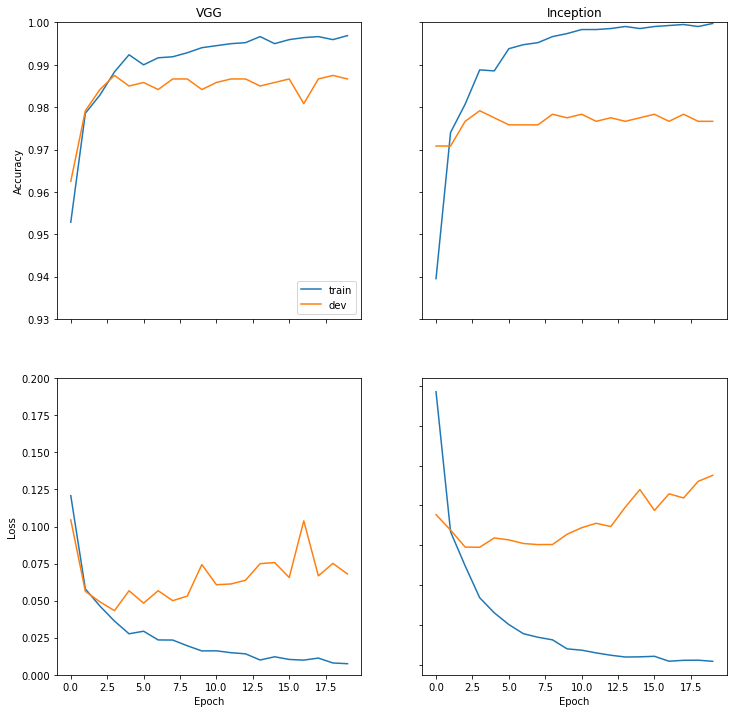

In [274]:
fig, axs = plt.subplots(2, 2, figsize=(12,12)) #, sharex=True, sharey=True)

axs[0, 0].plot(vgg_history.history['acc'])
axs[0, 0].plot(vgg_history.history['val_acc'])
axs[0, 0].set_title('VGG')
axs[0, 0].set(xlabel='Epoch', ylabel='Accuracy')
axs[0, 0].legend(['train', 'dev'], loc='lower right')
axs[0, 0].set_ylim([0.93, 1])

axs[0, 1].plot(incep_history.history['acc'])
axs[0, 1].plot(incep_history.history['val_acc'])
axs[0, 1].set_title('Inception')
axs[0, 1].set_ylim([0.93, 1])

axs[1, 0].plot(vgg_history.history['loss'])
axs[1, 0].plot(vgg_history.history['val_loss'])
axs[1, 0].set(xlabel='Epoch', ylabel='Loss')
axs[1, 0].set_ylim([0, 0.2])

axs[1, 1].plot(incep_history.history['loss'])
axs[1, 1].plot(incep_history.history['val_loss'])
axs[1, 1].set(xlabel='Epoch')
axs[1, 0].set_ylim([0, 0.2])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Several things can be noted right away from these plots:
1. Training lines look good: accuracy goes up, loss goes down.
2. However, dev set accuracy stays almost on the same level, and dev loss even goes up  with training. This latter may be a sign of overfitting to train data.
3. VGG performs slightly better, achieving 0.9867 accuracy on dev set vs 0.9767 for Inception

## Make predictions for test set

In [84]:
predictions = model.predict_classes(test_features)
prob = model.predict(test_features)

errors = np.where(predictions != test_labels[:,1])[0]
print("Number of errors = {}/{}".format(len(errors),test_labels.shape[0]))

Number of errors = 10/600


### Display wrongly labelled test pics

In [126]:
# Get IDs of the wrongly labelled test images in the original (before shuffling) numeration
error_ids = np.array([test_ids[i] for i in errors], dtype=np.int32)
error_truth = np.array([test_labels[i] for i in errors], dtype=np.int32)[:,1] # get ship/noship labels as just 1 and 0
false_positives = error_ids[error_truth==0]
false_negatives = error_ids[error_truth==1]
print("There are {} false positives and {} false negatives".format(len(false_positives), len(false_negatives)))

There are 4 false positives and 6 false negatives


False positives:

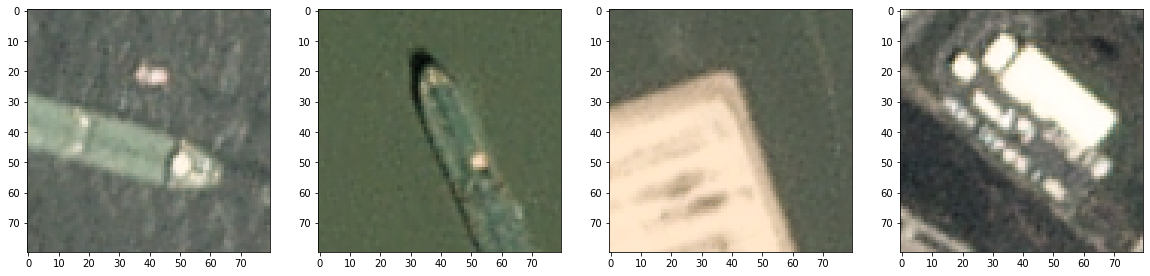

In [127]:
columns = 4
rows = 1

fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    img = images[false_positives[i-1]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

False negatives:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


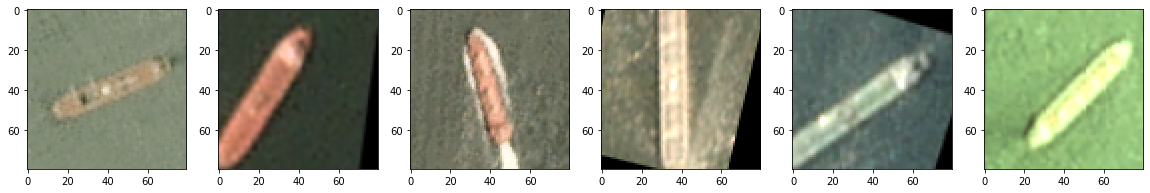

In [129]:
columns = 6
rows = 1

fig=plt.figure(figsize=(20, 20))
for i in range(1, columns*rows +1):
    img = images[false_negatives[i-1]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [136]:
import dill as pickle
with open('images.dill', 'wb') as file:
    pickle.dump(images, file)

In [137]:
model.save('model.h5')